In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [81]:

# Import the two csv file
user_eng= pd.read_csv('takehome_user_engagement.csv')
users = pd.read_csv('takehome_users.csv', encoding='latin-1')

In [82]:
# print the head of user data frame
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [83]:
# print the head of user_eng data frame
user_eng.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [84]:
user_eng.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [85]:
# Convert the time_stamp column to dtype datetime
user_eng['time_stamp'] = pd.to_datetime(user_eng['time_stamp'])

In [86]:
# Resample the data to daily
daily_users = user_eng.groupby('user_id').resample('1D', on='time_stamp').sum().drop('user_id', axis=1)

In [87]:
# Reset the index
daily_users.reset_index(inplace=True)

In [88]:
# Remove all the invalid entries that were made during resampling
daily_users = daily_users[daily_users['visited'] != 0]

# Create a column for daily visits
daily_users['daily_visits'] = 1

In [89]:
# Resample the data to weekly
weekly_users = daily_users.groupby('user_id').resample('1W', on='time_stamp').sum().drop('user_id', axis=1)


In [90]:
weekly_users = weekly_users[weekly_users['visited'] != 0]

In [91]:
weekly_users['adopted_user'] = weekly_users['daily_visits'].apply(lambda x: 1 if x >= 3 else 0)

In [92]:
# Check if the visited and daily_visits columns are equivalent
weekly_users['visited'].equals(weekly_users['daily_visits'])

True

In [93]:
weekly_users.head()

visited  daily_visits  adopted_user
user_id time_stamp                                     
1       2014-04-27        1             1             0
2       2013-11-17        1             1             0
        2013-12-01        1             1             0
        2013-12-15        1             1             0
        2013-12-29        1             1             0

In [94]:
# Reset the index
weekly_users.reset_index(inplace=True)

# Group by the data and take the sum of daily_visits and adopted_user
grouped_users = weekly_users.groupby('user_id').agg({'daily_visits': 'sum', 'adopted_user': 'sum'}).reset_index()

In [95]:
# Turn the adoped_user to a binary column
grouped_users['adopted_user'] = grouped_users['adopted_user'].apply(lambda x: 1 if x > 0 else 0)

In [96]:
grouped_users.head()

,user_id,daily_visits,adopted_user
0,1,1,0
1,2,14,1
2,3,1,0
3,4,1,0
4,5,1,0


In [97]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [98]:
# Sanity check to make sure no user ids were lost
assert grouped_users['user_id'].nunique() == user_eng['user_id'].nunique()

In [99]:
# Print the number of user ids in each dataset
print (users['object_id'].nunique())
print (grouped_users['user_id'].nunique())

12000
8823


In [100]:
# Convert the last_session_creation_time to datetime object
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'], unit='s')

# Convert the creation_time to datetime object
users['creation_time'] = pd.to_datetime(users['creation_time'])

In [101]:
# Merge the user engagement data with user data
merged_users = users.merge(grouped_users, how='left', left_on='object_id', right_on='user_id')

# Drop the user_id column
merged_users.drop('user_id', axis=1, inplace=True)

In [102]:
merged_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
 10  daily_visits                8823 non-null   float64       
 11  adopted_user                8823 non-null   float64   

In [103]:
merged_users[merged_users['last_session_creation_time'].isnull()].head(10)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,daily_visits,adopted_user
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaT,1,1,74,NaN,NaN,NaN
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaT,0,0,302,NaN,NaN,NaN
11,12,2014-04-17 23:48:38,Mathiesen Lærke,LaerkeLMathiesen@cuvox.de,ORG_INVITE,NaT,0,0,130,9270.0,NaN,NaN
14,15,2013-07-16 21:33:54,Theiss Ralf,RalfTheiss@hotmail.com,PERSONAL_PROJECTS,NaT,0,0,175,NaN,NaN,NaN
15,16,2013-02-11 10:09:50,Engel René,ReneEngel@hotmail.com,PERSONAL_PROJECTS,NaT,0,0,211,NaN,NaN,NaN
17,18,2013-08-24 00:26:46,Gregersen Celina,CelinaAGregersen@jourrapide.com,GUEST_INVITE,NaT,0,0,2,3153.0,NaN,NaN
25,26,2013-07-28 00:53:32,Wexler Florian,FlorianWexler@jourrapide.com,ORG_INVITE,NaT,0,0,56,11857.0,NaN,NaN
31,32,2013-04-17 16:21:30,Perez Timothy,TimothyJPerez@yahoo.com,PERSONAL_PROJECTS,NaT,1,1,98,NaN,NaN,NaN
33,34,2014-02-03 20:55:18,Holm Sara,SaraMHolm@hotmail.com,ORG_INVITE,NaT,0,0,33,3721.0,NaN,NaN
34,35,2013-08-01 10:55:26,Krueger Dieter,DieterKrueger@gustr.com,PERSONAL_PROJECTS,NaT,0,0,59,NaN,NaN,NaN


In [104]:
merged_users[merged_users['invited_by_user_id'].isnull()].head(10)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,daily_visits,adopted_user
6,7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,2012-12-20 13:24:32,0,1,37,NaN,1.0,0.0
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaT,1,1,74,NaN,NaN,NaN
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaT,0,0,302,NaN,NaN,NaN
10,11,2013-12-26 03:55:54,Paulsen Malthe,MaltheAPaulsen@gustr.com,SIGNUP,2013-12-27 03:55:54,0,0,69,NaN,1.0,0.0
13,14,2012-10-11 16:14:33,Rivera Bret,BretKRivera@gmail.com,SIGNUP,2012-10-12 16:14:33,0,0,0,NaN,1.0,0.0
14,15,2013-07-16 21:33:54,Theiss Ralf,RalfTheiss@hotmail.com,PERSONAL_PROJECTS,NaT,0,0,175,NaN,NaN,NaN
15,16,2013-02-11 10:09:50,Engel René,ReneEngel@hotmail.com,PERSONAL_PROJECTS,NaT,0,0,211,NaN,NaN,NaN
18,19,2013-05-24 14:56:36,Collins Arlene,ArleneRCollins@gmail.com,SIGNUP,2013-05-30 14:56:36,1,0,0,NaN,2.0,0.0
19,20,2014-03-06 11:46:38,Helms Mikayla,lqyvjilf@uhzdq.com,SIGNUP,2014-05-29 11:46:38,0,0,58,NaN,7.0,1.0
20,21,2013-01-22 12:27:42,Hunter Alfie,AlfieHunter@gmail.com,PERSONAL_PROJECTS,2013-01-22 12:27:42,0,0,54,NaN,1.0,0.0


In [105]:
merged_users['invited_by_user_id'].describe()

count     6417.000000
mean      5962.957145
std       3383.761968
min          3.000000
25%       3058.000000
50%       5954.000000
75%       8817.000000
max      11999.000000
Name: invited_by_user_id, dtype: float64

In [106]:
merged_users['last_session_creation_time'].fillna(merged_users['creation_time'], inplace=True)

# Fill the null values in invited_by_user_id
merged_users['invited_by_user_id'].fillna(0, inplace=True)

In [107]:
# Now fill the null values from merging (all with 0's)
merged_users['daily_visits'].fillna(0, inplace=True)

merged_users['adopted_user'].fillna(0, inplace=True)

In [108]:
merged_users['invited_by_user_id'] = merged_users['invited_by_user_id'].astype('int')

merged_users['adopted_user'] = merged_users['adopted_user'].astype('int')

In [109]:
# Create a list of binary columns
BINARY = ['opted_in_to_mailing_list', 'enabled_for_marketing_drip']

# Assign the numerical column to a variable
NUMERICAL = 'daily_visits'

BINARY.append(NUMERICAL)

In [110]:
# Split the dataframe into target and non-target
target = merged_users[merged_users['adopted_user'] == 1]
non_target = merged_users[merged_users['adopted_user'] == 0]

(array([1.1166e+04, 2.6100e+02, 1.6300e+02, 1.1200e+02, 9.2000e+01,
        8.0000e+01, 5.3000e+01, 4.2000e+01, 2.2000e+01, 9.0000e+00]),
 array([  0. ,  60.6, 121.2, 181.8, 242.4, 303. , 363.6, 424.2, 484.8,
        545.4, 606. ]),
 <BarContainer object of 10 artists>)

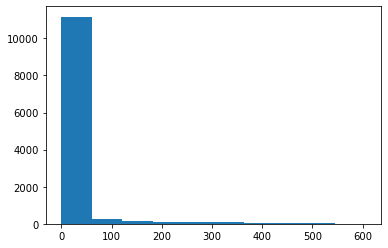

In [111]:
# Check distribution for numerical data
plt.hist(merged_users[NUMERICAL])

In [112]:
print (len(target))
print(len(non_target))

1445
10555


The data in daily_visits has a very strong right skew. I won't address this now, but I willscale it down with StandardScaler later.



In [113]:
# Create a column for creation_to_active
merged_users['creation_to_active'] = (merged_users['last_session_creation_time'] - merged_users['creation_time']).dt.days + 1

# Create a column for login_perc
merged_users['login_perc'] = merged_users['daily_visits'] / merged_users['creation_to_active']

In [114]:
# Create a column for email domain
merged_users['email_domain'] = merged_users['email'].apply(lambda x: x.split('@')[-1])

In [115]:
merged_users[merged_users['creation_to_active'] == 1].shape

(6204, 15)

In [116]:
merged_users['email_domain'].nunique()

1184

In [117]:
# Droping the unnecessary columns
merged_users.drop(['creation_time', 'name', 'email', 'last_session_creation_time'], axis=1, inplace=True)

In [118]:
merged_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_source             12000 non-null  object 
 2   opted_in_to_mailing_list    12000 non-null  int64  
 3   enabled_for_marketing_drip  12000 non-null  int64  
 4   org_id                      12000 non-null  int64  
 5   invited_by_user_id          12000 non-null  int32  
 6   daily_visits                12000 non-null  float64
 7   adopted_user                12000 non-null  int32  
 8   creation_to_active          12000 non-null  int64  
 9   login_perc                  12000 non-null  float64
 10  email_domain                12000 non-null  object 
dtypes: float64(2), int32(2), int64(5), object(2)
memory usage: 1.0+ MB


In [119]:
from sklearn.preprocessing import StandardScaler

In [120]:
# Split the data into X(variables) and y(target)
X = merged_users.drop(['object_id', 'adopted_user'], axis=1)
y = merged_users['adopted_user']

In [121]:
# Define the numerical columns
NUMERICAL = ['daily_visits', 'creation_to_active', 'login_perc']

# Define the categorical columns
CATEGORICAL = [col for col in merged_users.columns if col not in NUMERICAL]

# Remove object_id and adopted_user column from the categorical list
CATEGORICAL.remove('object_id')
CATEGORICAL.remove('adopted_user')

In [122]:
# Transform the numerical columns with the StandardScaler
numerical_data = StandardScaler().fit_transform(X[NUMERICAL])

# Create the numerical dataframe
numerical_df = pd.DataFrame(numerical_data, columns=NUMERICAL)

# Copy the categorical columns to another dataframe
categorical_df = X[CATEGORICAL].copy()

# Transform the categorical columns in pd.get_dummies
for col in CATEGORICAL:
    categorical_dummies = pd.get_dummies(categorical_df[col]).rename(columns=lambda x: col+str(x))
    categorical_df = categorical_df.join(categorical_dummies)
    del categorical_df[col]

In [123]:
numerical_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   daily_visits        12000 non-null  float64
 1   creation_to_active  12000 non-null  float64
 2   login_perc          12000 non-null  float64
dtypes: float64(3)
memory usage: 281.4 KB


In [124]:
categorical_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Columns: 4175 entries, creation_sourceGUEST_INVITE to email_domainzwmry.com
dtypes: uint8(4175)
memory usage: 48.1 MB


In [125]:
# Merge the two dataframes
x = pd.concat([numerical_df, categorical_df], axis=1)

In [144]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV

In [145]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [146]:
rf = RandomForestClassifier(n_estimators=100)

# Fit the Pipeline with the training data
rf.fit(X_train, y_train)

RandomForestClassifier()

In [147]:
y_pred=rf.predict(X_test)

In [148]:
# metrics are used to find accuracy or error
from sklearn import metrics 
print()
 
# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))


ACCURACY OF THE MODEL:  0.985


In [149]:
print('roc_auc_score:', roc_auc_score(y_test, y_pred))    
print(classification_report(y_test, y_pred))

roc_auc_score: 0.9568771192664066
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2102
           1       0.96      0.92      0.94       298

    accuracy                           0.98      2400
   macro avg       0.97      0.96      0.96      2400
weighted avg       0.98      0.98      0.98      2400



##### Extracting the best feature parameter from model

In [127]:
cf = RandomForestClassifier(max_depth=10, random_state=200)

In [140]:
cf.fit(x,y)

RandomForestClassifier(max_depth=10, random_state=200)

In [142]:
# Extract the feature importances and zip it with the columns into a dataframe
importances = cf.feature_importances_
features = pd.DataFrame({'feature': x.columns, 'importance': importances})
features.sort_values(by='importance', ascending=False, inplace=True)

ValueError: 'v' is not a valid value for orientation; supported values are 'vertical', 'horizontal'

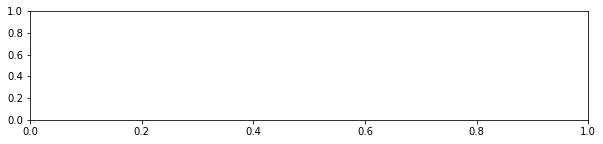

In [150]:
# Display a horizontal barplot with the first 5 feature importances
plt.figure(figsize=(10,2))
sns.barplot(x=features['importance'][:5], y=features['feature'][:5],orientation='v')

the above top values are the import for feature selection